In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import re

plt.style.use("ggplot")

def coordenadas_delegacion(nombre_delegacion: str, datos):
    for data in datos["features"]:
        if data["properties"]["NOMGEO"] == nombre_delegacion:
            return np.array(data["geometry"]["coordinates"][0])
        
def left_right_cords(hdf_file):
    dataset_path = "HDFEOS INFORMATION/StructMetadata.0"
    metadata = hdf_file[dataset_path][()].tobytes().decode("utf-8")
    upper_left_match = re.search(r"UpperLeftPointMtrs=\(([-\d.]+),([-\d.]+)\)", metadata)
    lower_right_match = re.search(r"LowerRightMtrs=\(([-\d.]+),([-\d.]+)\)", metadata)
    conversion = 1000000
    
    if upper_left_match and lower_right_match:
        upper_left_coords = (float(upper_left_match.group(1)) / conversion, float(upper_left_match.group(2)) / conversion)
        lower_right_coords = (float(lower_right_match.group(1)) / conversion, float(lower_right_match.group(2)) / conversion)
        return(upper_left_coords, lower_right_coords)
    
def arbrir_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)
    
def print_hdf5_structure(group, indent=0):
    for key in group.keys():
        print(" " * indent + f"- {key}")
        if isinstance(group[key], h5py.Group):
            print_hdf5_structure(group[key], indent + 2)

def recortar_imagen(image_matrix, coordenadas_municipio, upper_left):
    resolucion_x = 10 / image_matrix.shape[1]
    resolucion_y = 10 / image_matrix.shape[0]

    x_pixels = (coordenadas_municipio[:, 0] - upper_left[0]) / resolucion_x
    y_pixels = (upper_left[1] - coordenadas_municipio[:, 1]) / resolucion_y

    recorte_y = (np.ceil(y_pixels.min()).astype(int)-1, np.ceil(y_pixels.max()).astype(int)+1)
    recorte_x = (np.ceil(x_pixels.min()).astype(int)-1, np.ceil(x_pixels.max()).astype(int)+1)


    image_matrix_recortada = image_matrix[recorte_y[0]:recorte_y[1], recorte_x[0]:recorte_x[1]]
    imagen = np.clip(image_matrix_recortada, 0, np.percentile(image_matrix_recortada, 100))

    nuevos_x_pixels = x_pixels - recorte_x[0]
    nuevos_y_pixels = y_pixels - recorte_y[0]

    print(nuevos_x_pixels)
    print(nuevos_y_pixels)
    return imagen, nuevos_x_pixels, nuevos_y_pixels

In [3]:
delegaciones = [
    "Azcapotzalco",
    "Coyoacán",
    "Cuajimalpa de Morelos",
    "Gustavo A. Madero",
    "Iztacalco",
    "Iztapalapa",
    "La Magdalena Contreras",
    "Milpa Alta",
    "Álvaro Obregón",
    "Tláhuac",
    "Tlalpan",
    "Xochimilco",
    "Benito Juárez",
    "Cuauhtémoc",
    "Miguel Hidalgo",
    "Venustiano Carranza"
]


[28.78935273 28.89134071 28.97114811 ... 28.53723725 28.68215443
 28.78935273]
[2.42280721 2.4532391  2.47224729 ... 2.32443438 2.3857871  2.42280721]
[[  47.   47.   45. ... 1243. 1243.  752.]
 [  38.   37.   37. ... 1018.  752.  752.]
 [  38.   37.   37. ... 1018. 1033. 1033.]
 ...
 [   6.    7.    7. ...    8.    8.    9.]
 [   9.    6.    6. ...    8.    8.    9.]
 [  10.    9.    8. ...    7.    7.    5.]]


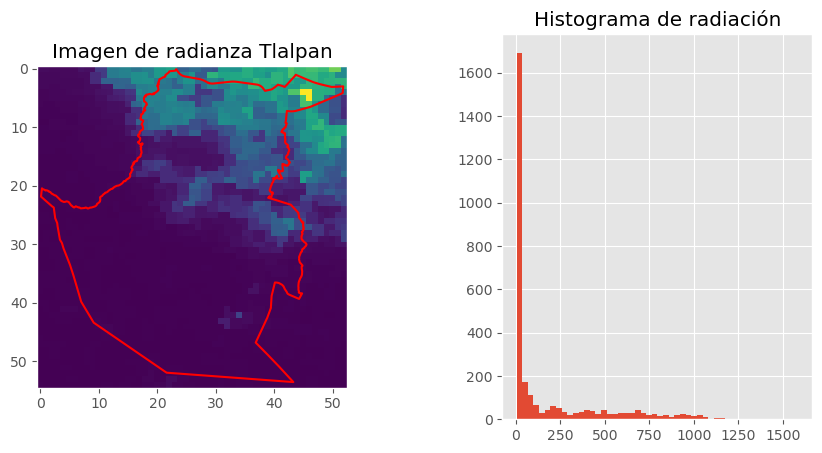

In [4]:
delegacion = "Tlalpan"
ruta_alcaldias = "Data/limite-de-las-alcaldas.json"
archivo_h5 = "Data/VNP46A1.A2025026.h08v07.001.2025027092706.h5"

datos_alcaldias = arbrir_json(ruta_alcaldias)

coordenadas_municipio = coordenadas_delegacion(delegacion, datos_alcaldias)
hdf_file = h5py.File(archivo_h5, "r")

upper_left, lower_right = left_right_cords(hdf_file)
image_path = "HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields/DNB_At_Sensor_Radiance_500m"

image_matrix = hdf_file[image_path][()]

imagen_recortada, nuevos_x_pixels, nuevos_y_pixels = recortar_imagen(image_matrix, coordenadas_municipio, upper_left)

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))


ax[0].imshow(imagen_recortada)
ax[0].plot(nuevos_x_pixels, nuevos_y_pixels, c="red")
ax[0].grid(False)
ax[0].set_title(f"Imagen de radianza {delegacion}")


ax[1].hist(imagen_recortada.flatten(), bins=50)
ax[1].grid(True)
ax[1].set_title("Histograma de radiación")


print(imagen_recortada)
plt.subplots_adjust(wspace=0.5)

plt.show()

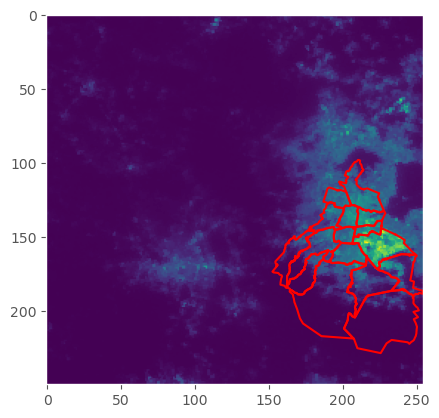

In [5]:
delegaciones = [
    "Azcapotzalco",
    "Coyoacán",
    "Cuajimalpa de Morelos",
    "Gustavo A. Madero",
    "Iztacalco",
    "Iztapalapa",
    "La Magdalena Contreras",
    "Milpa Alta",
    "Álvaro Obregón",
    "Tláhuac",
    "Tlalpan",
    "Xochimilco",
    "Benito Juárez",
    "Cuauhtémoc",
    "Miguel Hidalgo",
    "Venustiano Carranza"
]

ruta_alcaldias = "Data/limite-de-las-alcaldas.json"
archivo_h5 = "Data/VNP46A1.A2025026.h08v07.001.2025027092706.h5"
datos_alcaldias = arbrir_json(ruta_alcaldias)

for delegacion in delegaciones:
    
    coordenadas_municipio = coordenadas_delegacion(delegacion, datos_alcaldias)
    hdf_file = h5py.File(archivo_h5, "r")

    upper_left, lower_right = left_right_cords(hdf_file)
    image_path = "HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields/DNB_At_Sensor_Radiance_500m"

    image_matrix = hdf_file[image_path][()]

    resolucion_x = 10 / image_matrix.shape[1]
    resolucion_y = 10 / image_matrix.shape[0]

    x_pixels = (coordenadas_municipio[:, 0] - upper_left[0]) / resolucion_x
    y_pixels = (upper_left[1] - coordenadas_municipio[:, 1]) / resolucion_y

    plt.imshow(image_matrix[0:250, 0:255])
    plt.plot(x_pixels, y_pixels, c="red")
    plt.grid(False)
plt.show()

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import re

plt.style.use("ggplot")

def coordenadas_delegacion(nombre_delegacion: str, datos):
    for data in datos["features"]:
        if data["properties"]["NOMGEO"] == nombre_delegacion:
            return np.array(data["geometry"]["coordinates"][0])
        
def left_right_cords(hdf_file):
    dataset_path = "HDFEOS INFORMATION/StructMetadata.0"
    metadata = hdf_file[dataset_path][()].tobytes().decode("utf-8")
    upper_left_match = re.search(r"UpperLeftPointMtrs=\(([-\d.]+),([-\d.]+)\)", metadata)
    lower_right_match = re.search(r"LowerRightMtrs=\(([-\d.]+),([-\d.]+)\)", metadata)
    conversion = 1000000
    
    if upper_left_match and lower_right_match:
        upper_left_coords = (float(upper_left_match.group(1)) / conversion, float(upper_left_match.group(2)) / conversion)
        lower_right_coords = (float(lower_right_match.group(1)) / conversion, float(lower_right_match.group(2)) / conversion)
        return(upper_left_coords, lower_right_coords)
    
def arbrir_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)
    
def print_hdf5_structure(group, indent=0):
    for key in group.keys():
        print(" " * indent + f"- {key}")
        if isinstance(group[key], h5py.Group):
            print_hdf5_structure(group[key], indent + 2)

def aumentar_imagen(image_matrix, factor_escala = 2):
    imagen_aumentada = np.kron(image_matrix, np.ones((factor_escala, factor_escala)))
    return imagen_aumentada

def recortar_imagen(image_matrix, coordenadas_municipio, upper_left, factor_escala=2):
    # 1. Calcular resolución en la imagen original
    resolucion_x = 10 / image_matrix.shape[1]
    resolucion_y = 10 / image_matrix.shape[0]

    # 2. Convertir coordenadas a píxeles
    x_pixels = (coordenadas_municipio[:, 0] - upper_left[0]) / resolucion_x
    y_pixels = (upper_left[1] - coordenadas_municipio[:, 1]) / resolucion_y

    # 3. Definir área de recorte
    recorte_y = (np.ceil(y_pixels.min()).astype(int)-1, np.ceil(y_pixels.max()).astype(int)+1)
    recorte_x = (np.ceil(x_pixels.min()).astype(int)-1, np.ceil(x_pixels.max()).astype(int)+1)

    # 4. Recortar la imagen original
    image_matrix_recortada = image_matrix[recorte_y[0]:recorte_y[1], recorte_x[0]:recorte_x[1]]
    
    # 5. Aumentar imagen recortada
    imagen_aumentada = aumentar_imagen(image_matrix_recortada, factor_escala)

    # 6. Ajustar las coordenadas de los bordes según el factor de escala
    nuevos_x_pixels = (x_pixels - recorte_x[0]) * factor_escala
    nuevos_y_pixels = (y_pixels - recorte_y[0]) * factor_escala

    # 7. Clip para normalizar intensidad
    imagen = np.clip(imagen_aumentada, 0, np.percentile(imagen_aumentada, 100))

    return imagen, nuevos_x_pixels, nuevos_y_pixels


def distancia_puntos(x,y):
    return np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

def completar_bordes(nuevos_x_pixels, nuevos_y_pixels, coordenadas_bordes):
    for i in range(len(nuevos_x_pixels) - 1):
        distancia = distancia_puntos((nuevos_x_pixels[i], nuevos_y_pixels[i]), (nuevos_x_pixels[i+1], nuevos_y_pixels[i+1]))
        if distancia > 1:
                                      
            pendiente = (nuevos_y_pixels[i+1] - nuevos_y_pixels[i]) / (nuevos_x_pixels[i+1] - nuevos_x_pixels[i])
            recta = lambda x: pendiente * (x - nuevos_x_pixels[i]) + nuevos_y_pixels[i]
            x = np.linspace(nuevos_x_pixels[i], nuevos_x_pixels[i+1], 100)
            y = recta(x)
            for j in range(len(x)):
                coordenadas_bordes.append((int(x[j]), int(y[j])))

    return coordenadas_bordes

def dibujar_bordes(imagen_recortada, coordenadas_bordes):
    for i in range(len(coordenadas_bordes)):
        imagen_recortada[coordenadas_bordes[i][1], coordenadas_bordes[i][0]] = 2500

    return imagen_recortada

0.33333333333333376
-0.33333333333333365


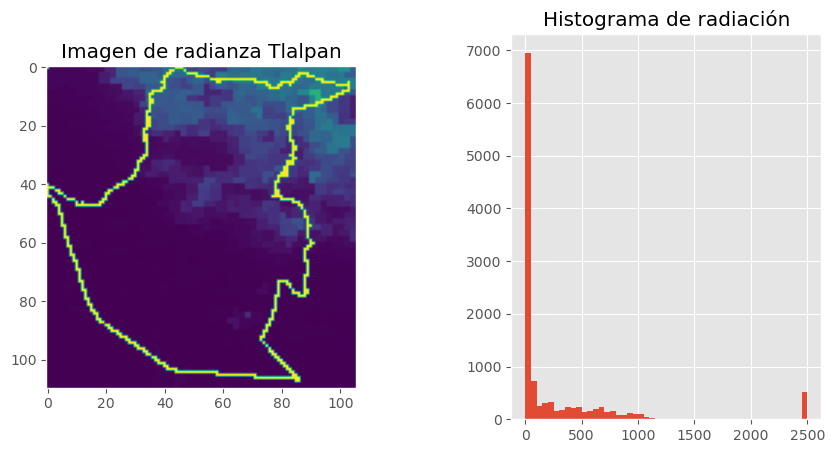

In [20]:
delegacion = "Tlalpan"
ruta_alcaldias = "Data/limite-de-las-alcaldas.json"
archivo_h5 = "Data/VNP46A1.A2025026.h08v07.001.2025027092706.h5"

datos_alcaldias = arbrir_json(ruta_alcaldias)

coordenadas_municipio = coordenadas_delegacion(delegacion, datos_alcaldias)
hdf_file = h5py.File(archivo_h5, "r")

upper_left, lower_right = left_right_cords(hdf_file)
image_path = "HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields/DNB_At_Sensor_Radiance_500m"

image_matrix = hdf_file[image_path][()]


#plt.imshow(np.clip(image_matrix, 0, np.percentile(image_matrix, 98)))
#plt.show()

imagen_municipio, nuevos_x_pixels, nuevos_y_pixels = recortar_imagen(image_matrix, coordenadas_municipio, upper_left)

#plt.imshow(imagen_municipio)
#plt.title("Recorte de la imagen satelital")
#plt.show()

#fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))

coordenadas_bordes = [] # Lista de coordenadas de pixeles de los bordes

for i in range(len(nuevos_y_pixels)):
    coordenadas_bordes.append((int(nuevos_x_pixels[i]), int(nuevos_y_pixels[i])))
    imagen_municipio[int(nuevos_y_pixels[i]), int(nuevos_x_pixels[i])] = 2500

#plt.imshow(imagen_municipio)
#plt.title("Imagen satelital bordes sin completar")
#plt.show()

coordenadas = completar_bordes(nuevos_x_pixels, nuevos_y_pixels, coordenadas_bordes)

imagen_municipio = dibujar_bordes(imagen_municipio, coordenadas)

#plt.imshow(imagen_municipio)
#plt.title("Imagen satelital bordes completos")
#plt.show()

a = 0
for i in range(len(nuevos_x_pixels)):
    a += (nuevos_x_pixels[i] - nuevos_x_pixels[i-1]) * (nuevos_y_pixels[i] + nuevos_y_pixels[i-1])
a = a / 2


gx = 1 / (6 * a) * np.sum((nuevos_x_pixels - np.roll(nuevos_x_pixels, 1)) * (nuevos_y_pixels + np.roll(nuevos_y_pixels, 1)))
gy = 1 / (6 * a) * np.sum((nuevos_y_pixels - np.roll(nuevos_y_pixels, 1)) * (nuevos_x_pixels + np.roll(nuevos_x_pixels, 1)))

imagen_municipio[gx.astype(int), gy.astype(int)] = 2500

print(gx)
print(gy)

fig,ax = plt.subplots(ncols = 2, figsize=(10, 5))
ax[0].imshow(imagen_municipio)
ax[0].grid(False)
ax[0].set_title(f"Imagen de radianza {delegacion}")


ax[1].hist(imagen_municipio.flatten(), bins=50)
ax[1].grid(True)
ax[1].set_title("Histograma de radiación")

plt.subplots_adjust(wspace=0.5)

plt.show()
